# Computer Vision 3: ResNet

This notebook is based on fastai's **[Chapter 14](https://github.com/fastai/fastbook/blob/master/14_resnet.ipynb)**.

Please read this chapter before looking at this review.

*I suggest opening this notebook in Colab (where it can be easier to use GPU).*
*If you want to run it locally, set up the **deep-learning** environment in your terminal with `conda env create -f environment.yml` and activate it in your preferred IDE.*

In [2]:
### FOR COLAB USERS ###
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.0 MB/s eta 0:00:00
Mounted at /content/gdrive


In [3]:
# ### FOR LOCAL USERS ###
# import fastai
# print(fastai.__version__)

# ! pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
from fastbook import *

# Data
### Imagenette data
Using the already-resized 160 px version

In [5]:
def get_data(url, presize, resize):
  path = untar_data(url)
  return DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(presize),
    batch_tfms=[
      *aug_transforms(min_scale=0.5, size=resize),
      Normalize.from_stats(*imagenet_stats)
    ],
  ).dataloaders(path, bs=128)

In [6]:
# get data
dls = get_data(URLs.IMAGENETTE_160, 160, 128) # presize to 128

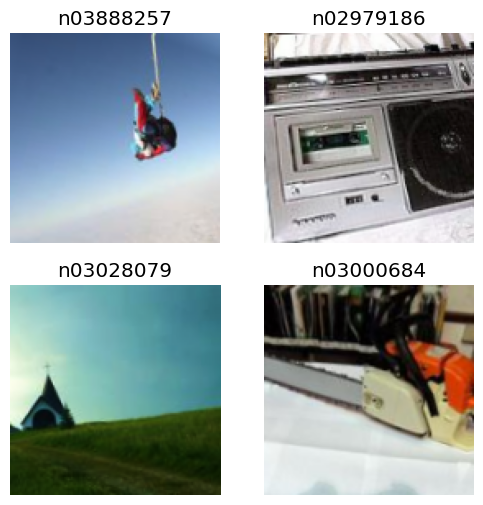

In [7]:
# examples
dls.show_batch(max_n=4)

### Bigger images

Don't need to do anything to account for the larger (224 pixel) images -- when you use a fully convolutional network, it'll just work!

In [8]:
big_dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

# Fully Convolutional Network
- Can't use same approach as the 3s vs 7s
  - That approach: use enough stride-2 convolutions so the final layer had a grid size of 1; flatten unit axes to get a vector for each image aka a matrix per mini-batch)
  - Too many stride-2 layers are needed to make final grid 1x1
  - Model could only use images the same size as the training images

- **Average pooling**
- Takes a picture, slices it into small pieces, jumbles them up, and decides what each piece looks


In [9]:
# take mean over x and y axes
# always converts a grid of activations into a single activation per image
def avg_pool(x): return x.mean((2,3))

- **Fully convolutional network**
  - Take the average of activations across a convolutional grid
  - Has a number of convolutional layers (some are stride-2)
  - Last layers = (1) adaptive average pooling layer (2) flatten layer to remove the unit axes, (3) linear layer
  - Really, only a good choice for objects that don't have a single correct orientation or size (e.g., like most natural photos)
  - Resulting activations: bs x ch x h x w (batch size, a certain number of channels, height, and width)
  - Will need to take the average over the last two dimensions and flatten the trailing 1 x 1 dimension

In [10]:
# define a block
# right now this is a convolution, but we can replace 'block' with other variants
def block(ni, nf): return ConvLayer(ni, nf, stride=2)

In [11]:
# fully convolutional network -- this is the same thing we did in the last notebook, except there's a linear layear at the end
def get_model():
  return nn.Sequential(
    block(3, 16),
    block(16, 32),
    block(32, 64),
    block(64, 128),
    block(128, 256),
    nn.AdaptiveAvgPool2d(1), # PyTorch's (better) version of average pooling
    Flatten(),
    nn.Linear(256, dls.c)
  )

In [12]:
# learn
def get_learner(m):
  return Learner(
    dls,
    m,
    loss_func=nn.CrossEntropyLoss(),
    metrics=accuracy
  ).to_fp16() # to_fp16 makes it take up less memory

learn = get_learner(get_model())

SuggestedLRs(valley=0.0012022644514217973)

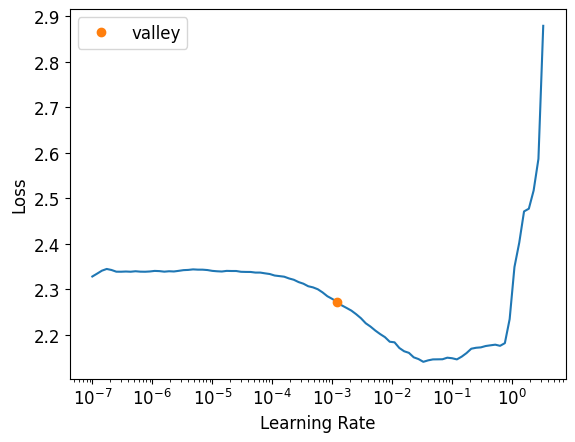

In [13]:
# find learning rate
learn.lr_find()

In [14]:
# evaluate
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.875976,2.017520,0.386752,00:32
1,1.532421,1.665877,0.484331,00:33
2,1.288033,1.232395,0.603312,00:33
3,1.142065,1.169642,0.625987,00:35
4,1.045077,1.052032,0.676433,00:32


# ResNet
- General idea (but not how it is implemented): Take a shallow network, and add more layers to make a deep network
  - First, make the new layers be an "identity map" -- returning the input without changing anything at all
  - Then, train the new layers to be useful.

- ResNet is a variation of this that allows you to train deeper models
  - In the stride-2 case, a ResNet block has 3 convolutions and a pooling layer
  - It "skips over" every second convolution
  - This skipping part is called the "skip connection" or "identity branch" -- we want the skip connection to be as close to an identity map as possibel
  - The skip blocks result in the same solution as the general idea above, but allows you to still initialize and use SGD to train the NNs in the usual way
  - The way they do this is to let a few stacked layers fit a residual mapping, instead of the otiginal, unreferenced mapping
  - "If the outcome of a given layer is x, when using a ResNet block that returns y = x+block(x) we're not asking the block to predict y, we are asking it to predict the difference between y and x. So the job of those blocks isn't to predict certain features, but to minimize the error between x and the desired y. A ResNet is, therefore, good at learning about slight differences between doing nothing and passing though a block of two convolutional layers (with trainable weights)."
  - Using skip connections also helps smooth the loss function, making training easier
  - Trick: use zero for the initial value of gamma in the last batchnorm layer of each block -- makes models train at higher learning rates

### Basic ResNet

**Minimally useful residual block**
- Can only handle a stride of 1
- Requires ni == nf: used when the input tensor is added to the output tensor --> the addition requires the dimensions of the tensors to be equal

In [15]:
# minimually useful resnet block
class ResBlock(Module):
  def __init__(self, ni, nf):
    self.convs = nn.Sequential(
      ConvLayer(ni,nf), # stride = 1
      ConvLayer(nf,nf, norm_type=NormType.BatchZero) # init the gamma weights of the last batchnorm layer to zero
    )

    def forward(self, x): return x + self.convs(x) # the output of the convolutional layers is added to the input tensor, resulting in the residual connection

**More useful residual block**
- Allows to change the strides
- Recall from previous notebook: batch normalization
  - Used to normalize the inputs of a layer (aka subtract the batch mean and divide by the batch standard deviation)
  - Helps with training stability and accelerating convergence
  - Each input feature is scaled by gamma. This is a learnable parameter, so the NN will figure out the best value
  - A gamma initialization of 0: gamma parameter starts with 0s (initial scaling factor = 0), aka input features are not scaled
- Note: the simplest possible convolution is one where the kernel size is 1 (aka 1x1 convolution)

In [16]:
# more useful resnet block of 2 convolutional layers
def _conv_block(ni,nf,stride):
  return nn.Sequential(
    ConvLayer(ni, nf, stride=stride), # first convoluational layer -- reduces the input's spatial dimensions if the stride > 1
    ConvLayer( # second convolutional layer
        nf, # ni is not specified because it takes the number of output channels from the previous layer (nf)
        nf,
        act_cls=None, #act_cls = None (remove ReLU from the final convolution -- move it to after you add the skip connection)
        norm_type=NormType.BatchZero # Batch normalization with gamma initialization to zero
    )
  )

In [17]:
# create the residual block class
class ResBlock(Module):
  def __init__(self, ni, nf, stride=1):

    # block of convolutional layers
    self.convs = _conv_block(ni,nf,stride)

    # an additional convolutional layer that is applied when ni != nf
    # if ni == nf, no operation is performed -- return input unchanged (noop = no operation)
    self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)

    # average pooling layer that is applied when the stride != 1
    # if stride == 1, no operation is performed
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # do nothing if stride == 1

  def forward(self, x):
    # self.convs(x): applies the convolutional block to the input tensor x
    # self.pool(x): applies the pooling operation (average pooling) to x
    # self.idconv(..): applies the additional convolutional layer to the result of the pooling operation
    # add the output of the convolutional block and the additional convolutional layer
    # then apply relu: the idea is that thw whole ResNet block is like a layer, so activation comes after the layer
    return F.relu(
      self.convs(x) + self.idconv(self.pool(x))
    )

In [18]:
# redefine block with what we just wrote above
def block(ni,nf): return ResBlock(ni, nf, stride=2)

In [19]:
# learn and fit -- not much better (yet); just lets us train deeper models
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.937366,1.852753,0.356943,00:32
1,1.675513,1.608685,0.462166,00:31
2,1.386088,1.262908,0.605605,00:33
3,1.173281,1.092677,0.654267,00:30
4,1.037172,1.020240,0.678217,00:33


In [20]:
# create a model that's twice as deep
def block(ni, nf):
  return nn.Sequential(
    ResBlock(ni, nf, stride=2),
    ResBlock(nf, nf)
  )

In [21]:
# learn and fit -- better!
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.958087,1.853048,0.357962,00:34
1,1.636416,1.505300,0.507006,00:31
2,1.342561,1.177931,0.613503,00:33
3,1.099436,0.976027,0.688408,00:33
4,0.953283,0.956015,0.695541,00:35


### State of the Art ResNet
- "Stem" of the network (first few layers)
  - Doesn't start with ResNet blocks
  - Instead, starts with a few convolutional layers, followed by a max pooling layer
  - Better to keep early layers simple / fast, because that's where most of the computation happens (more pixels). Later layers have less computation, but most of the parameters

- Modern ResNet
  - 4 groups of resnet blocks with different size filters
  - Each group starts with stride-2 block except the first one, since that's following a MaxPooling layer
  - The various versions of the models (ResNet-18, -34, -50, etc.) just change the number of blocks in each of those groups

- Deep ResNets (depth of 50 or more layers)
  - Bottleneck layer: "Instead of stacking two convolutions with a kernel size of 3, bottleneck layers use three different convolutions: two 1 x 1 (at the beginning and the end) and one 3 x 3" -- lets you use more filters in the same amount of time


**ResNet Stem**
- Refers to the initial block or module that processes the input data at the beginning of a CV network
- Plays a crucial role in extracting important features from the raw input
- Also helps prepare the data for further processing by the subsequent layers, including the residual blocks
- Process:
  - The combination of convolutional layers and max pooling forms the stem of the ResNet architecture
  - The convolutional layers are responsible for feature extraction
  - The max pooling layer helps downsample the spatial dimensions of the input

In [22]:
def _resnet_stem(*sizes):
  """
  sizes = number of input and output channels for each convolutional layer in the stem (representing the number of channels in each layer of the stem)
  """
  return [ # first create a list of convolutional layers that process the input sizes into a desired output size
    ConvLayer( # iterates over pairs of consecutive sizes in the sizes argument (the two sizes below)
      sizes[i], # input size
      sizes[i+1], # output size
      3, # kernel size (3x3)
      stride = 2 if i==0 else 1 # stride = 2 if it's the first layer in the stem, otherwise stride = 1
    ) for i in range(len(sizes)-1) # this creates the iteration of sizes mentioned above
  ] + [
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # pooling operation reduces the spatial dimensions of the output
  ]

In [23]:
# 3 input channels
# 32 output channels for the FIRST convolutional layer
# 32 output channels for the SECOND convolutional layer
# 64 output channels for the THIRD convolutional layer
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

**ResNet Class**
Process
- Stem (defined above)
- Block sizes
  - The sizes (number of channels) of different blocks in the network
  - Initialized based on the stem configuration and adjusted by a specified expansion factor
  - Expansion factor is applied to increase the channel sizes of subsequent blocks
- Blocks
  - For each layer specified in the layers argument, a block is created using the `_make_layer` method
  - Each block is a sequence of residual blocks (ResBlock instances) with varying numbers of layers
- Linear Head
  - Adaptive pooling layer, flattening, linear layer
  - Linear layer produces outputs

In [24]:
# modern resnet
class ResNet(nn.Sequential):
  def __init__(self, n_out, layers, expansion=1):
    # stem -- what we created above
    stem = _resnet_stem(3,32,32,64)

    # block sizes
    self.block_szs = [64, 64, 128, 256, 512] # different filter sizes
    for i in range(1,5): self.block_szs[i] *= expansion # increase channel sizes for later blocks

    # blocks (see function below)
    blocks = [self._make_layer(*o) for o in enumerate(layers)] # create a series of n_layers blocks

    # linear head
    super().__init__(
      *stem, *blocks,
      nn.AdaptiveAvgPool2d(1), # adaptive average pooling layer
      Flatten(), # flattening
      nn.Linear(self.block_szs[-1], n_out) # linear layer
    )

  def _make_layer(self, idx, n_layers):
    # generates a layer (sequence of residual blocks) based on the specified number of layers (n_layers)
    # layer is created by stacking multiple ResBlock instances
    # each ResBlock has convolutional layers, an identity convolution (if needed), and activation function
    stride = 1 if idx==0 else 2
    ch_in,ch_out = self.block_szs[idx:idx+2]

    # first one goes from ch_in to ch_out with the indicated stride
    # all the others are blocks of stride 1 with ch_out to ch_out tensors
    return nn.Sequential(*[
      ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1) #
      for i in range(n_layers)
    ])

In [25]:
# resnet-18 -- more accurate (because more channels) and still fast!
rn = ResNet(dls.c, [2,2,2,2])
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.652159,3.727129,0.320255,00:30
1,1.308323,1.678863,0.528153,00:31
2,1.064793,1.295491,0.590064,00:31
3,0.877607,0.976947,0.696306,00:33
4,0.759246,0.773006,0.751083,00:33


### Deeper Network
Only really used for ResNet-50, 101, and 152. (Shallower ResNet-18 and 34 don't usually use the bottleneck design, but it does work on them!)

**Bottleneck design**

Used to capture hierarchical features in the input data, while still being computationally efficient
- First layer = 1x1 convolution --> dimension reduction
  - Reduces the number of input channels (ni) to 1/4 of the output channels (nf)
  - Helps reduce dimensionality (the number of input channels) and computational cost (reduces number of parameters)
- Second layer = 3x3 convolution with stride --> feature extraction (spatial hierarchies and patterns)
  - Number of input and output channels is 1/4 of the total number of channels (nf).
  - The stride helps control downsampling
  - This is also where the features are extracted
- Third layer = 1x1 convolution --> dimension restoration
  - Increases the number of channels back to the original size (nf)
  - No activation is applied after this layer
  - Use batch normalization with gamma initialization to zero

In [26]:
# bottleneck design
def _conv_block(ni,nf,stride):
  return nn.Sequential(
    ConvLayer(ni, nf//4, 1), # dimension reduction
    ConvLayer(nf//4, nf//4, stride=stride), # feature exatraction, controls downsampling
    ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero)) # dimension restoration

In [27]:
# deeper networks mostly show improvements when training for many epochs
rn = ResNet(
  big_dls.c, # using bigger images
  [3,4,6,3], # number of residual blocks in each of the four stages (layers) of the ResNet
  4 # expansion factor (adjusts the number of channels in the internal bottleneck blocks)
)
learn = get_learner(rn)
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.585016,1.655765,0.477707,00:32
1,1.364448,1.853915,0.487134,00:33
2,1.258244,1.403065,0.563567,00:32
3,1.172581,1.296121,0.591083,00:32
4,1.074749,1.627967,0.544204,00:32
5,1.003950,1.649523,0.513885,00:32
6,0.883232,1.388978,0.583185,00:33
7,0.782089,1.586423,0.576306,00:33
8,0.731763,0.977060,0.707006,00:33
9,0.656341,0.924405,0.735287,00:33


*Bonus: add Mixup and train for 100 epochs*